# Using Machine Learning to Estimate Ratings of Bangladeshi Restaurants from Reviews

## Data Exploration and Visualization

### Data importation

The dataset I will be working with is sourced from [Mendeley Data](https://data.mendeley.com/datasets/wc87kpk6ks/1), a reputable open-source data repository. 
This particular dataset consists of user reviews extracted from restaurants located in various places in the city of Dhaka

Key information such as the review text, user ratings, and the date of the review post were compiled.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import re
import emoji
import nltk
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

# Ensure that NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load the data from a CSV file
rws = pd.read_csv('/Users/antoinem/Desktop/project-ada/3projet/data/datareview.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/antoinem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/antoinem/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Data Vizualization

In the following step, I'm going to change the dataset to better suit my needs by removing columns that are not pertinent to our analysis. Additionally, I will assign more descriptive names to certain columns to enhance clarity and facilitate easier data handling.

In [2]:
# Drop the 'Unnamed: 0' and 'createdAt' columns from the dataframe 
rws = rws.drop(columns=['Unnamed: 0', 'createdAt', 'reviewerName',])

# Rename specific columns to more descriptive names:
rws.rename(columns={'text': 'review', 'ratingvalue': 'rating'}, inplace=True)

# Convert the 'rating' column to numeric
rws['rating'] = pd.to_numeric(rws['rating'], errors='coerce')

# Display the first 5 rows
print(rws.head())

                                              review  rating
0  To tell you the truth, they sell fried chicken...       1
1                                  Crispy was so bad       3
2  The restaurant provided leas items which I ord...       1
3  already send you a picture about my meal. tota...       1
4                                Excellent as before       5


In the following sections, we will explore the dataset in more detail. We'll begin by presenting a series of visualizations that will give us insights into the distribution, trends, and relationships within the data.

Let's dive into the visuals to better understand our dataset.

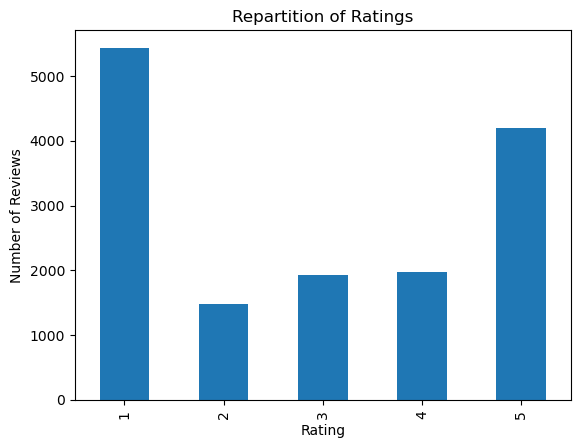

In [3]:
# Define the desired order of ratings
desired_order = [1, 2, 3, 4, 5]

# Calculate the counts of each rating
rating_counts = rws['rating'].value_counts()

# Reindex the rating_counts Series with the desired order
rating_counts = rating_counts.reindex(desired_order)

# Plot the repartition of ratings with the updated x-axis order
rating_counts.plot(kind='bar')

# Set the labels and title
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Repartition of Ratings')

# Show the plot
plt.show()


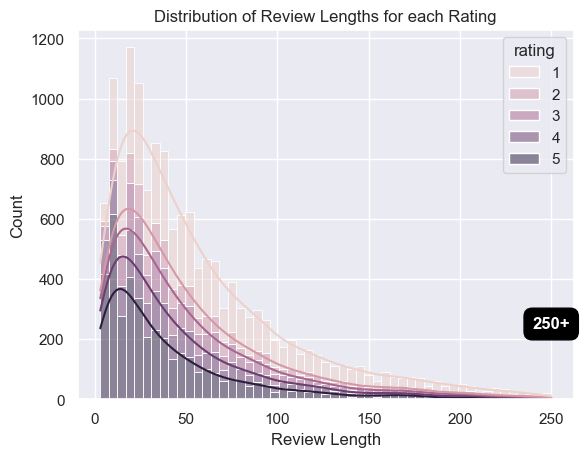

In [4]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set the style of the plot
sns.set(style="darkgrid")

# Calculate the length of reviews
rws['review_length'] = rws['review'].apply(len)

# Filter the review lengths greater than 250
filtered_rws = rws[rws['review_length'] <= 250]

# Plot the distribution of review lengths for each rating
sns.histplot(data=filtered_rws, x="review_length", hue="rating", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Review Lengths for each Rating")
plt.xlabel("Review Length")
plt.ylabel("Count")

# Add a label for review lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()

In [5]:
longest_review = rws.loc[rws['review_length'].idxmax(), 'review']
print(longest_review)


When the delivery man arrived at my house, he called me to let me know that he had sent the food upstairs with my guard. I asked him to kindly wait downstairs so that I can send him the money to which he replied said the food has been paid for. I was quite taken aback and said that's not possible because I had opted for COD payment, and he just said "achcha ami dekhtesi" and then he just hung up on my face " I mean? Excuse me? I obviously lost my temper, called him back and asked him what sort of nonsense is this and why he kept the phone on my face. He was dumbfounded and did not say a word. I asked him to wait downstairs while I send the guard with the payment. Once your delivery-man had received the payment, he had the audacity to call me back and ask why I said what I said. To recall the conversation, when he hung up on my face my exact words when I called him back were "apni amar mukher upor keno phone rakhlen? Faizlami peyechen apni? Ami toh bolchi cash eh payment hobe, apni nich

In [6]:
rws.drop('review_length', axis=1, inplace=True)

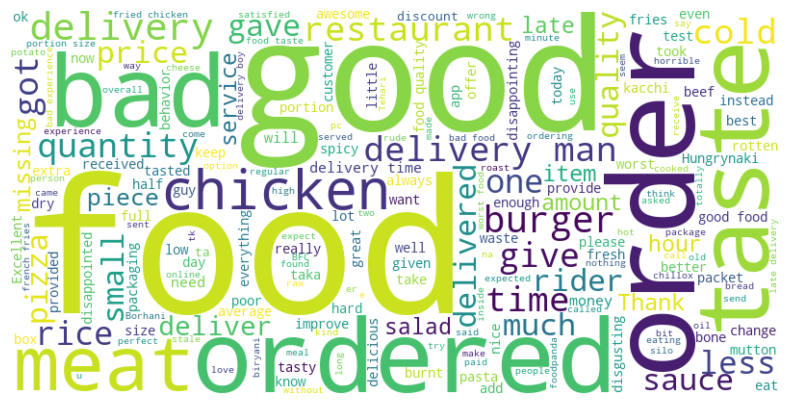

In [7]:
# Concatenate all the reviews into a single string
all_reviews = ' '.join(rws['review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Text Preprocessing and Data Categorization

### Data Categorization

I will create two categories for my reviews: Positive reviews, which are those with a rating strictly greater than 3, and Negative reviews, which include reviews with a rating strictly less than 3.

In [8]:
# Define a function that categorizes the rating
def categorize_rating(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    else:
        return 'Neutral'  # This handles ratings exactly equal to 3, if any

# Apply the function to the 'rating' column
rws['rating'] = rws['rating'].apply(categorize_rating)

# Remove rows where the review_category is 'Neutral'
rws = rws[rws['rating'] != 'Neutral']

# Display the DataFrame to verify that 'Neutral' reviews have been removed
print(rws.head())

                                              review rating
0  To tell you the truth, they sell fried chicken...      0
2  The restaurant provided leas items which I ord...      0
3  already send you a picture about my meal. tota...      0
4                                Excellent as before      1
5  They forgot to include the beverages that were...      0


### Vizualization of the Categorization

Let's take a look at our newly categorized data to gain a clearer insight into how our future models will perform.

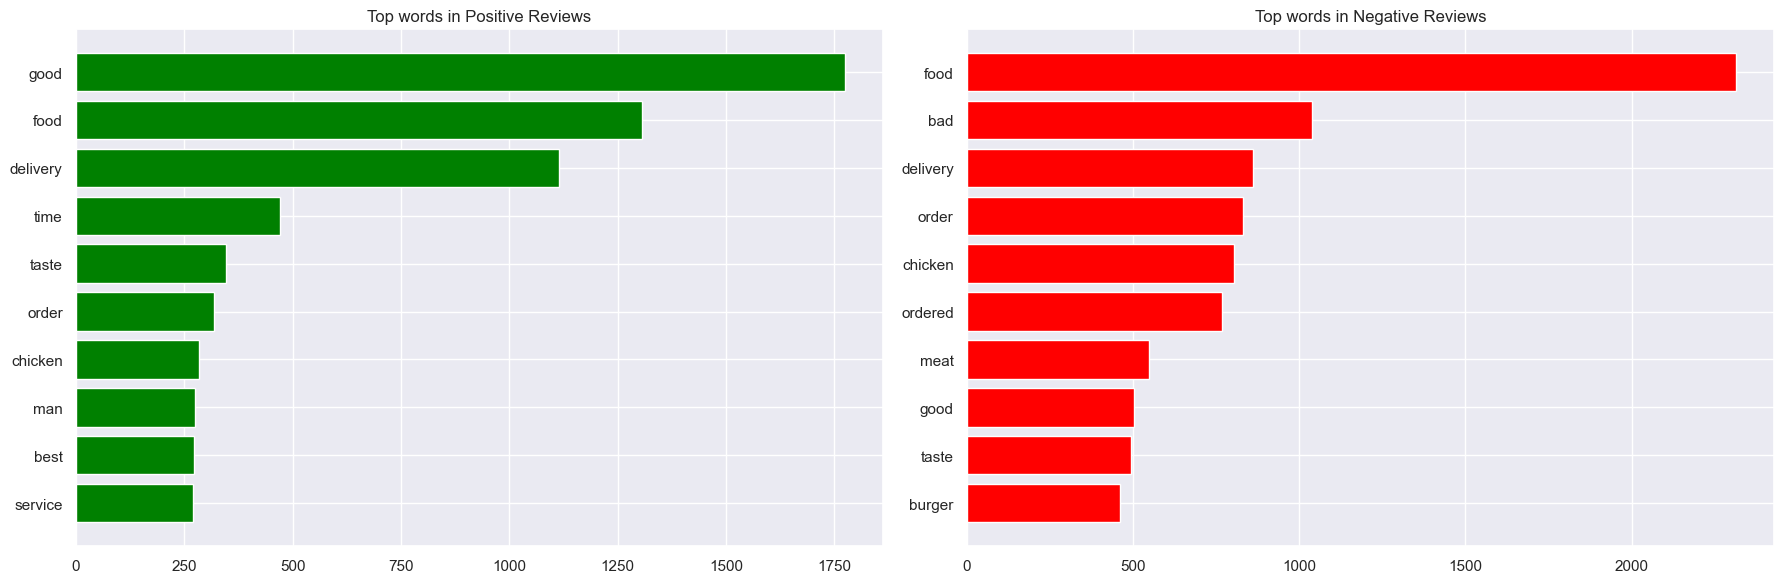

In [9]:
# Tokenize the reviews, remove stopwords, and count the word frequencies for positive and negative reviews separately.

# Function to clean and tokenize text
def clean_tokenize(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# Separate positive and negative reviews
positive_reviews = rws[rws['rating'] == 1]['review']
negative_reviews = rws[rws['rating'] == 0]['review']

# Apply the cleaning and tokenization function
positive_tokens = positive_reviews.apply(clean_tokenize).sum()
negative_tokens = negative_reviews.apply(clean_tokenize).sum()

# Count the frequencies of words
positive_freq = Counter(positive_tokens)
negative_freq = Counter(negative_tokens)

# Get the 10 most common words in positive and negative reviews
most_common_positive = positive_freq.most_common(10)
most_common_negative = negative_freq.most_common(10)

# Separate the words and their counts for the plot
positive_words, positive_counts = zip(*most_common_positive)
negative_words, negative_counts = zip(*most_common_negative)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot for positive reviews
ax[0].barh(positive_words, positive_counts, color='green')
ax[0].set_title('Top words in Positive Reviews')
ax[0].invert_yaxis()  # Labels read top-to-bottom

# Plot for negative reviews
ax[1].barh(negative_words, negative_counts, color='red')
ax[1].set_title('Top words in Negative Reviews')
ax[1].invert_yaxis()  # Labels read top-to-bottom

# Display the plot
plt.tight_layout()
plt.show()


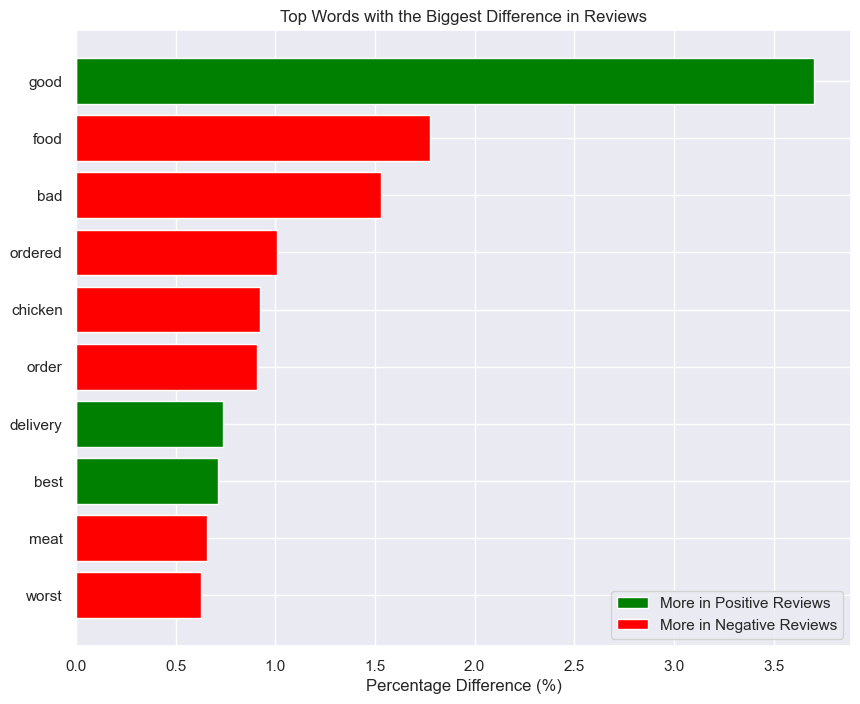

In [10]:
# Calculate the frequency difference for each word
frequency_diff = {word: positive_freq[word] - negative_freq[word] for word in set(positive_freq) | set(negative_freq)}

# Calculate the percentage difference for each word
total_pos_reviews = sum(positive_freq.values())
total_neg_reviews = sum(negative_freq.values())
percentage_diff = {word: (count / total_pos_reviews * 100 if count > 0 else count / total_neg_reviews * 100)
                   for word, count in frequency_diff.items()}

# Sort the words by the biggest absolute percentage difference
sorted_words = sorted(percentage_diff.items(), key=lambda x: abs(x[1]), reverse=True)

# Select the top words with the biggest difference
top_words = sorted_words[:10]  # Adjust the number as needed

# Split words and their percentage difference
words, differences = zip(*top_words)

# Split into positive and negative differences
pos_diffs = [percentage_diff[word] if percentage_diff[word] > 0 else 0 for word in words]
neg_diffs = [-percentage_diff[word] if percentage_diff[word] < 0 else 0 for word in words]

# Plotting
plt.figure(figsize=(10, 8))
y_pos = range(len(words))
plt.barh(y_pos, pos_diffs, color='green', label='More in Positive Reviews')
plt.barh(y_pos, neg_diffs, color='red', label='More in Negative Reviews')
plt.yticks(y_pos, words)
plt.xlabel('Percentage Difference (%)')
plt.title('Top Words with the Biggest Difference in Reviews')
plt.legend()
plt.gca().invert_yaxis()  # Highest percentages on top
plt.show()


### Text Preprocessing and Spliting

I will do text preprocessing in two distinct ways: 

**Large Cleaning Process :** This includes negation handling, emoji removal, lemmatization etc...

**Small Cleaning Process :** This maintaining more of the text's raw form.

*It will be beneficial to evaluate both versions with various models later on.*

Then I will also split the data into training and testing sets.

In [11]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def handle_negation(text):
    if text is None:
        return text
    # Pattern to detect negations followed by an alphanumeric word
    negation_pattern = re.compile(r'\b(not|no|never|none|nothing|nowhere|neither|nobody|cannot)\b[\s]*(\w+)')
    text = negation_pattern.sub(lambda x: f'{x.group(1)}_{x.group(2)}', text)
    return text

def full_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Handle negation
    text = handle_negation(text)
    # Remove emojis
    text = emoji.replace_emoji(text, replace='')
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize text
    words = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # POS tagging
    nltk_pos_tagged = nltk.pos_tag(words)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_pos_tagged)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, tag) if tag else word for word, tag in wordnet_tagged]
    return ' '.join(lemmatized_words)

def raw_clean_text(text):
    # If text is None or empty, return it as it is
    if text is None or text == '':
        return text
    # Tokenize text
    words = word_tokenize(text)
    return ' '.join(words)

In [12]:
# Balance the dataset
# Separate the dataset into positives and negatives
positive_rws = rws[rws['rating'] == 1]
negative_rws = rws[rws['rating'] == 0]

# Downsample the majority class (positive reviews) to match the minority class (negative reviews)
min_count = min(len(positive_rws), len(negative_rws))
balanced_positive = positive_rws.sample(n=min_count, random_state=42)
balanced_negative = negative_rws.sample(n=min_count, random_state=42)

# Combine back to a single balanced dataframe
balanced_rws = pd.concat([balanced_positive, balanced_negative])

# Now perform a stratified split on the balanced dataset
train_rws, test_rws = train_test_split(balanced_rws, test_size=0.2, stratify=balanced_rws['rating'], random_state=42)

# Apply the thorough cleaning to the training and test sets
# Create new DataFrame for cleaned versions including ratings
cleaned_train = pd.DataFrame({
    'review': train_rws['review'].apply(full_clean_text),
    'rating': train_rws['rating']
})
cleaned_test = pd.DataFrame({
    'review': test_rws['review'].apply(full_clean_text),
    'rating': test_rws['rating']
})

# Apply the minimal cleaning to the training and test sets
# Create new DataFrame for raw versions including ratings
raw_train = pd.DataFrame({
    'review': train_rws['review'].apply(raw_clean_text),
    'rating': train_rws['rating']
})
raw_test = pd.DataFrame({
    'review': test_rws['review'].apply(raw_clean_text),
    'rating': test_rws['rating']
})

In [13]:
# Print the first two reviews from the cleaned training set
print("First two reviews from the Cleaned Training Set:")
print(cleaned_train['review'].iloc[0])
print(cleaned_train['review'].iloc[1])
print("\n")

# Print the first two reviews from the cleaned test set
print("First two reviews from the Cleaned Test Set:")
print(cleaned_test['review'].iloc[0])
print(cleaned_test['review'].iloc[1])
print("\n")

# Assuming the same indices can be used for the raw sets, since the split was stratified based on the rating
print("First two reviews from the Raw Training Set:")
print(raw_train['review'].iloc[0])
print(raw_train['review'].iloc[1])
print("\n")

print("First two reviews from the Raw Test Set:")
print(raw_test['review'].iloc[0])
print(raw_test['review'].iloc[1])

First two reviews from the Cleaned Training Set:
bhuna khichuri plenty meatbeef ittaste also good
delivery time


First two reviews from the Cleaned Test Set:
bad food cold soggy bag rip entire soda go waste no_cheese cheeseburger
please continue consistency pizza excellent taste really fresh also whole family could enjoy definitely order


First two reviews from the Raw Training Set:
Bhuna khichuri had plenty of meat ( Beef ) in it.Taste was also good .
delivery time


First two reviews from the Raw Test Set:
It was very bad . The food was cold and soggy . The bag ripped and my entire soda went to waste . And there was no cheese in my cheeseburger
Please continue this consistency ! The pizza is excellent ! It tasted really fresh ! Also my whole family could enjoy it . Definitely ordering again .


In [14]:
# Count the occurrences of each class in the 'rating' column for both training and test sets
count_train = Counter(cleaned_train['rating'])
count_test = Counter(cleaned_test['rating'])
count_raw_train = Counter(raw_train['rating'])
count_raw_test = Counter(raw_test['rating'])

print("Counts for Cleaned Training Set:", count_train)
print("Counts for Cleaned Test Set:", count_test)
print("Counts for Raw Training Set:", count_raw_train)
print("Counts for Raw Test Set:", count_raw_test)


Counts for Cleaned Training Set: Counter({1: 4942, 0: 4942})
Counts for Cleaned Test Set: Counter({0: 1236, 1: 1236})
Counts for Raw Training Set: Counter({1: 4942, 0: 4942})
Counts for Raw Test Set: Counter({0: 1236, 1: 1236})


## Modelling

### Naive Bayes with cleaned and raw data

In [15]:
# Convert ratings to numeric codes if they are categorical
cleaned_train['rating'] = cleaned_train['rating'].astype('category').cat.codes
cleaned_test['rating'] = cleaned_test['rating'].astype('category').cat.codes

cX_train = cleaned_train['review']
cy_train = cleaned_train['rating']
cX_test = cleaned_test['review']
cy_test = cleaned_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
cX_train_tfidf = tfidf_vectorizer.fit_transform(cX_train)
cX_test_tfidf = tfidf_vectorizer.transform(cX_test)

# Training a Multinomial Naive Bayes model
model_0c = MultinomialNB()
model_0c.fit(cX_train_tfidf, cy_train)

# Predicting the ratings
start_time = timeit.default_timer()
cy_pred = model_0c.predict(cX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0c_time_per_instance = (end_time - start_time) / len(cX_test)

# Calculate other metrics
m0c_accuracy = accuracy_score(cy_test, cy_pred)
m0c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Change average method as appropriate
m0c_recall = recall_score(cy_test, cy_pred, average='weighted')
m0c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0c_accuracy:.2%}", f"{m0c_precision:.3f}", f"{m0c_recall:.3f}", f"{m0c_f1:.3f}", f"{m0c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


Model Performance          Results
         accuracy           78.80%
        precision            0.793
           recall            0.788
         f1_score            0.787
    time/instance 0.000000 seconds


In [16]:
# Convert ratings to numeric codes if they are categorical
raw_train['rating'] = raw_train['rating'].astype('category').cat.codes
raw_test['rating'] = raw_test['rating'].astype('category').cat.codes

rX_train = raw_train['review']
ry_train = raw_train['rating']
rX_test = raw_test['review']
ry_test = raw_test['rating']

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
rX_train_tfidf = tfidf_vectorizer.fit_transform(rX_train)
rX_test_tfidf = tfidf_vectorizer.transform(rX_test)

# Training a Multinomial Naive Bayes model
model_0r = MultinomialNB()
model_0r.fit(rX_train_tfidf, ry_train)

# Predicting the ratings
start_time = timeit.default_timer()
ry_pred = model_0r.predict(rX_test_tfidf)
end_time = timeit.default_timer()

# Calculate time per instance
m0r_time_per_instance = (end_time - start_time) / len(rX_test)

# Calculate other metrics
m0r_accuracy = accuracy_score(ry_test, ry_pred)
m0r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use weighted to account for label imbalance
m0r_recall = recall_score(ry_test, ry_pred, average='weighted')
m0r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m0r_accuracy:.2%}", f"{m0r_precision:.3f}", f"{m0r_recall:.3f}", f"{m0r_f1:.3f}", f"{m0r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

Model Performance          Results
         accuracy           78.92%
        precision            0.795
           recall            0.789
         f1_score            0.788
    time/instance 0.000000 seconds


In [17]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Time per Instance'])

def store_results(model_name, accuracy, precision, recall, f1_score, time_per_instance):
    # Append the new results to the DataFrame
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': f"{accuracy:.2%}",
        'Precision': f"{precision:.3f}",
        'Recall': f"{recall:.3f}",
        'F1 Score': f"{f1_score:.3f}",
        'Time per Instance': f"{time_per_instance:.6f} seconds"
    }

# Store the results for the cleaned text model
store_results('Model_0c', m0c_accuracy, m0c_precision, m0c_recall, m0c_f1, m0c_time_per_instance)

# Store the results for the raw text model
store_results('Model_0r', m0r_accuracy, m0r_precision, m0r_recall, m0r_f1, m0r_time_per_instance)

# View the consolidated results
print(results_df)


      Model Accuracy Precision Recall F1 Score Time per Instance
0  Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1  Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds


### FNN with cleaned data

In [18]:
import gensim
from gensim.models import Word2Vec
import numpy as np

# Assuming 'cleaned_train' and 'cleaned_test' are pre-processed and tokenized
# Tokenize reviews if not already done
cleaned_train['tokenized_reviews'] = cleaned_train['review'].apply(gensim.utils.simple_preprocess)
cleaned_test['tokenized_reviews'] = cleaned_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_c = Word2Vec(sentences=cleaned_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
cX_train_vec = vectorize_reviews(cleaned_train['tokenized_reviews'], word2vec_model_c)
cX_test_vec = vectorize_reviews(cleaned_test['tokenized_reviews'], word2vec_model_c)


In [19]:
# Assuming 'cleaned_train' and 'cleaned_test' are pre-processed and tokenized
# Tokenize reviews if not already done
raw_train['tokenized_reviews'] = raw_train['review'].apply(gensim.utils.simple_preprocess)
raw_test['tokenized_reviews'] = raw_test['review'].apply(gensim.utils.simple_preprocess)

# Train Word2Vec model
word2vec_model_r = Word2Vec(sentences=raw_train['tokenized_reviews'], vector_size=100, window=5, min_count=2, workers=4)

# Function to vectorize texts
def vectorize_reviews(reviews, model):
    vectorized = []
    for tokens in reviews:
        # Filter tokens to ensure the model has a vector for them
        valid_tokens = [token for token in tokens if token in model.wv]
        if valid_tokens:
            # If there are valid tokens, calculate the mean of their vectors
            review_vec = np.mean([model.wv[token] for token in valid_tokens], axis=0)
        else:
            # If no valid tokens, use a zero vector
            review_vec = np.zeros(model.vector_size)
        vectorized.append(review_vec)
    return np.array(vectorized)


# Vectorize training and testing data
rX_train_vec = vectorize_reviews(raw_train['tokenized_reviews'], word2vec_model_r)
rX_test_vec = vectorize_reviews(raw_test['tokenized_reviews'], word2vec_model_r)


In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model building function without compile arguments
def create_model(neurons=64, dropout_rate=0.5, activation='relu'):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(cX_train_vec.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Wrap the model with KerasClassifier and include compile-time parameters
model = KerasClassifier(model=create_model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the grid search parameters
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.3, 0.5],
    'model__activation': ['sigmoid'],
    'optimizer': ['rmsprop','Nadam']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit GridSearchCV
grid_result = grid.fit(cX_train_vec, cy_train)  # Make sure y_train is correctly defined

In [69]:
# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.659753 using {'model__activation': 'tanh', 'model__dropout_rate': 0.1, 'model__neurons': 128, 'optimizer': 'Nadam'}


In [70]:
best_params = grid_result.best_params_

model_1c = create_model(
    neurons=best_params['model__neurons'],
    dropout_rate=best_params['model__dropout_rate'],
    activation=best_params['model__activation']
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


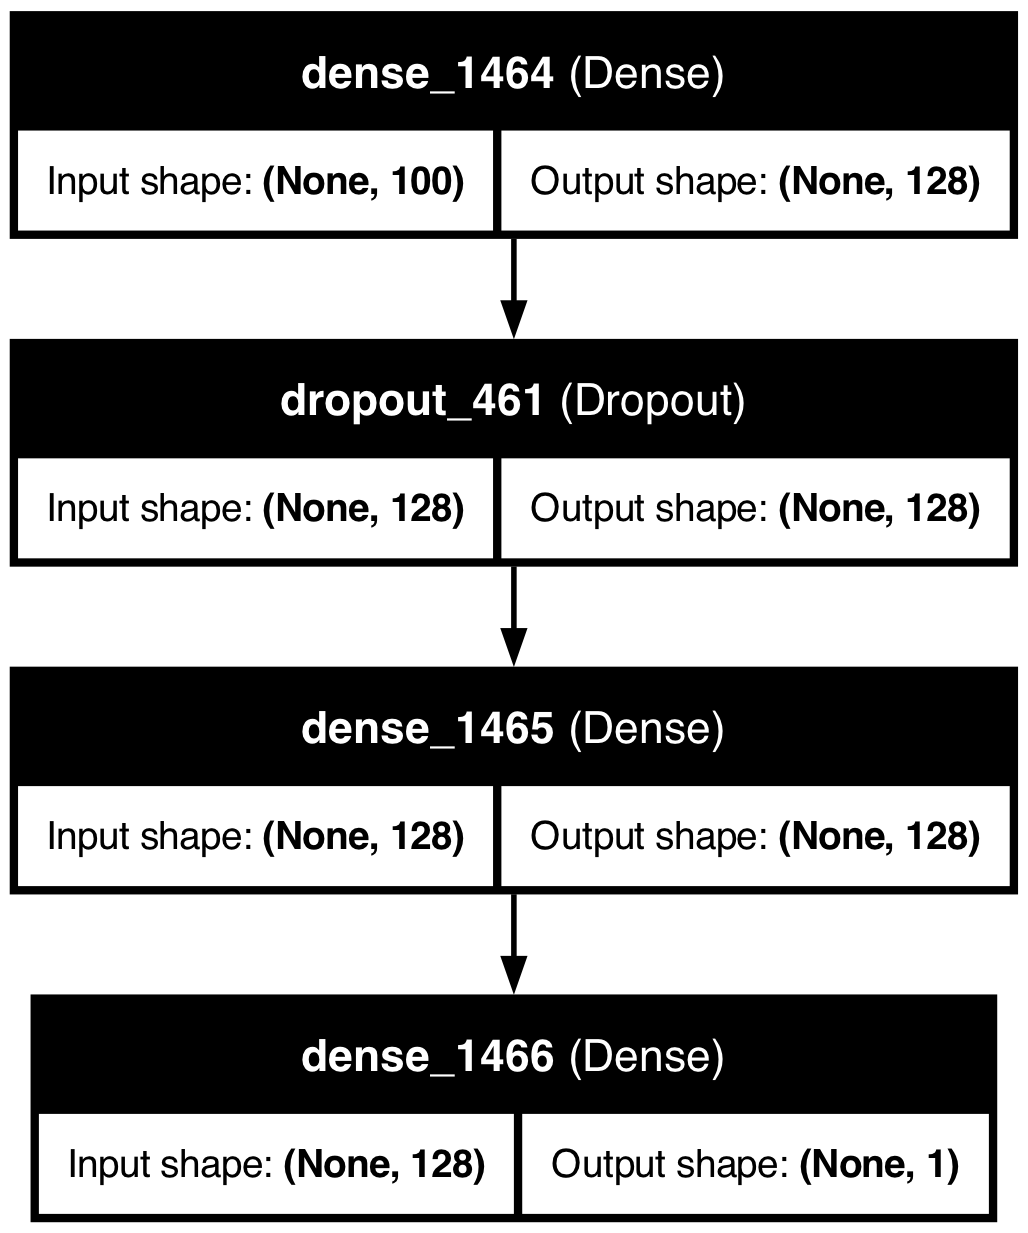

In [71]:
from tensorflow.keras.utils import plot_model
import pydot

# Generate the plot
plot_model(model_1c, to_file='model_1c_network.png', show_shapes=True, show_layer_names=True)

In [72]:
model_1c.compile(
    optimizer=best_params['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# EarlyStopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

# ReduceLROnPlateau to reduce the learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=20, 
    verbose=1, 
    min_lr=0.001
)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Changed from best_model.h5 to best_model.keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [74]:
model_1c_history = model_1c.fit(
    cX_train_vec, cy_train,
    epochs=70,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/70
230/248 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5325 - loss: 0.6922
Epoch 1: val_loss improved from inf to 0.68807, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5353 - loss: 0.6913 - val_accuracy: 0.5260 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/70
242/248 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6046 - loss: 0.6592
Epoch 2: val_loss improved from 0.68807 to 0.61762, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6051 - loss: 0.6589 - val_accuracy: 0.6606 - val_loss: 0.6176 - learning_rate: 0.0010
Epoch 3/70
234/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.6256
Epoch 3: val_loss improved from 0.61762 to 0.60011, saving model to best_model.keras
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6488 - loss: 0.6252 - val_accuracy: 0.6839 - val_loss: 0.6001 - learning_rate: 0.0010
Epoch 4/70
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.67

In [75]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_1c.predict(cX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1c_time_per_instance = (end_time - start_time) / len(cX_test_vec)

# Calculate accuracy, precision, recall, and f1 score
m1c_accuracy = accuracy_score(cy_test, cy_pred)
m1c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1c_recall = recall_score(cy_test, cy_pred, average='weighted')
m1c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1c_accuracy:.2%}", f"{m1c_precision:.3f}", f"{m1c_recall:.3f}", f"{m1c_f1:.3f}", f"{m1c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Model Performance          Results
         accuracy           73.22%
        precision            0.740
           recall            0.732
         f1_score            0.730
    time/instance 0.000415 seconds


In [76]:
store_results('Model_1c', m1c_accuracy, m1c_precision, m1c_recall, m1c_f1, m1c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   72.01%     0.725  0.720    0.718  0.000132 seconds
3   Model_1r   49.23%     0.425  0.492    0.345  0.000145 seconds
4   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
5   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
6   Model_1r   56.96%     0.654  0.570    0.501  0.000137 seconds
7   Model_1r   68.85%     0.747  0.689    0.669  0.000130 seconds
8   Model_1c   71.64%     0.719  0.716    0.716  0.000145 seconds
9   Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
10  Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
11  Model_1c   73.22%     0.740  0.732    0.730  0.000415 seconds


### FNN with raw data

In [78]:
# Define the model building function without compile arguments
def create_model(neurons=64, dropout_rate=0.5, activation='relu'):
    model = Sequential([
        Dense(neurons, activation=activation, input_shape=(rX_train_vec.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons, activation=activation),
        Dense(1, activation='sigmoid')
    ])
    return model

# Wrap the model with KerasClassifier and include compile-time parameters
model = KerasClassifier(model=create_model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the grid search parameters
param_grid = {
    'model__neurons': [32, 64, 128],
    'model__dropout_rate': [0.1, 0.3, 0.5],
    'model__activation': ['sigmoid'],
    'optimizer': ['rmsprop','Nadam']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)

# Fit GridSearchCV
grid_result = grid.fit(rX_train_vec, ry_train)  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5051 - loss: 0.7010
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5235 - loss: 0.6910
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5143 - loss: 0.6930
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5018 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5033 - loss: 0.6952
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5200 - loss: 0.7039
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5294 - loss: 0.6904
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5343 - loss: 0.7013
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5305 - loss: 0.6903
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5085 - loss: 0.7086
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5206 - loss: 0.6918
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5424 - loss: 0.6891
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5292 - loss: 0.6938
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4993 - loss: 0.6958
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5214 - loss: 0.6918
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5130 - loss: 0.7008
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5298 - loss: 0.6920
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5265 - loss: 0.6956
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5302 - loss: 0.6915
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5211 - loss: 0.6935
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5367 - loss: 0.6892
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5242 - loss: 0.7025
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5180 - loss: 0.6957
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5170 - loss: 0.7015
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5333 - loss: 0.6937
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5219 - loss: 0.6898
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5274 - loss: 0.7023
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5084 - loss: 0.7415
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5248 - loss: 0.6920
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5172 - loss: 0.6984
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5057 - loss: 0.6950
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4954 - loss: 0.6980
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5214 - loss: 0.6962
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5226 - loss: 0.6925
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5061 - loss: 0.7017
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5012 - loss: 0.7043
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5309 - loss: 0.6928
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5135 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5224 - loss: 0.7100
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4988 - loss: 0.6959
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5122 - loss: 0.6934
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5299 - loss: 0.6901
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5211 - loss: 0.6919
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5188 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5128 - loss: 0.6941
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5191 - loss: 0.6993
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5064 - loss: 0.6942
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5322 - loss: 0.7002
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5136 - loss: 0.6977
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5096 - loss: 0.7022
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5137 - loss: 0.6984
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5271 - loss: 0.7002
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5186 - loss: 0.6967
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5197 - loss: 0.6929
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4961 - loss: 0.7081
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.5017 - loss: 0.6951
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5132 - loss: 0.6935
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5141 - loss: 0.6973
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5335 - loss: 0.7291
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5142 - loss: 0.6953
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5094 - loss: 0.7059
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5238 - loss: 0.6914
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5224 - loss: 0.7110
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5152 - loss: 0.6948
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5220 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5064 - loss: 0.6969
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5083 - loss: 0.6997
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5121 - loss: 0.6957
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4949 - loss: 0.6961
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5114 - loss: 0.6945
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5193 - loss: 0.6945
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5323 - loss: 0.6920
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5429 - loss: 0.6898
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5147 - loss: 0.6983
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5235 - loss: 0.6971
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5178 - loss: 0.6998
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5088 - loss: 0.7144
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5138 - loss: 0.7075
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5115 - loss: 0.6993
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5063 - loss: 0.7014
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5333 - loss: 0.6995
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


309/309 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5419 - loss: 0.6876


In [79]:
# Print best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.614225 using {'model__activation': 'sigmoid', 'model__dropout_rate': 0.3, 'model__neurons': 64, 'optimizer': 'Nadam'}


In [80]:
best_params = grid_result.best_params_

model_1r = create_model(
    neurons=best_params['model__neurons'],
    dropout_rate=best_params['model__dropout_rate'],
    activation=best_params['model__activation']
)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model_1r.compile(
    optimizer=best_params['optimizer'],
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [82]:
model_1r_history = model_1r.fit(
    rX_train_vec, ry_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,  # Using 20% of the training data as validation data,
    verbose=1
)

Epoch 1/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5082 - loss: 0.7018 - val_accuracy: 0.5933 - val_loss: 0.6722
Epoch 2/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6064 - loss: 0.6639 - val_accuracy: 0.6201 - val_loss: 0.6558
Epoch 3/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6160 - loss: 0.6573 - val_accuracy: 0.6388 - val_loss: 0.6480
Epoch 4/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6332 - loss: 0.6454 - val_accuracy: 0.6449 - val_loss: 0.6429
Epoch 5/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6304 - loss: 0.6432 - val_accuracy: 0.6191 - val_loss: 0.6478
Epoch 6/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6436 - loss: 0.6376 - val_accuracy: 0.6515 - val_loss: 0.6337
Epoch 7/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6535 - loss: 0.6284 - val_accuracy: 0.6338 - val_loss: 0.6359
Epoch 8/150
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6349 - loss: 0.6318 - val_accu

In [83]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_1r.predict(rX_test_vec)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m1r_time_per_instance = (end_time - start_time) / len(rX_test_vec)

# Calculate accuracy, precision, recall, and f1 score
m1r_accuracy = accuracy_score(ry_test, ry_pred)
m1r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m1r_recall = recall_score(ry_test, ry_pred, average='weighted')
m1r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m1r_accuracy:.2%}", f"{m1r_precision:.3f}", f"{m1r_recall:.3f}", f"{m1r_f1:.3f}", f"{m1r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model Performance          Results
         accuracy           69.70%
        precision            0.713
           recall            0.697
         f1_score            0.691
    time/instance 0.000236 seconds


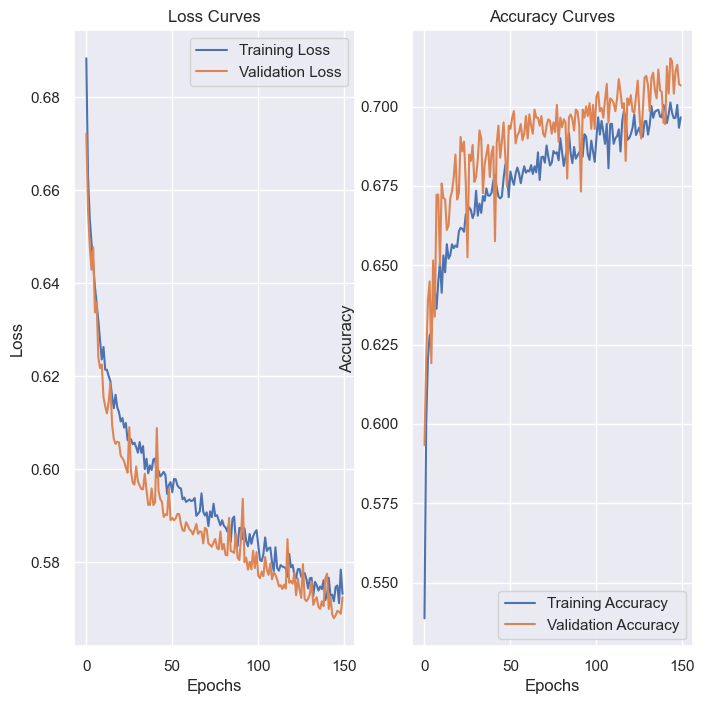

In [84]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
    history: TensorFlow History object.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Use the function with your model's history
plot_loss_curves(model_1r_history)


In [85]:
store_results('Model_1r', m1r_accuracy, m1r_precision, m1r_recall, m1r_f1, m1r_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   72.01%     0.725  0.720    0.718  0.000132 seconds
3   Model_1r   49.23%     0.425  0.492    0.345  0.000145 seconds
4   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
5   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
6   Model_1r   56.96%     0.654  0.570    0.501  0.000137 seconds
7   Model_1r   68.85%     0.747  0.689    0.669  0.000130 seconds
8   Model_1c   71.64%     0.719  0.716    0.716  0.000145 seconds
9   Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
10  Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
11  Model_1c   73.22%     0.740  0.732    0.730  0.000415 seconds
12  Model_1r   69.70%     0.713  0.697    0.691  0.000236 seconds


### LSTM (single layer) with cleaned and raw data

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV

def create_model(lstm_units=50, learning_rate=0.01):
    model = Sequential([
        LSTM(units=lstm_units, input_shape=(1, 100)),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Wrap the model with KerasClassifier without specifying epochs or batch size here
model = KerasClassifier(build_fn=create_model, lstm_units=20, learning_rate=0.01, verbose=0)

# Define the grid search parameters
param_grid = {
    'lstm_units': [20, 50, 100],
    'learning_rate': [0.01, 0.001, 0.0001],
    'batch_size': [10, 20],
    'epochs': [5, 10]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(cX_train_vec.reshape(-1, 1, 100), cy_train)


# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [98]:
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']


In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Create the model with the best parameters found
model_2c = create_best_model(best_lstm_units, best_learning_rate)

# Model Summary
print(model_2c.summary())


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_651"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2028 (Dense)              │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,501 (314.46 KB)

 Trainable params: 80,501 (314.46 KB)

 Non-trainable params: 0 (0.00 B)

None


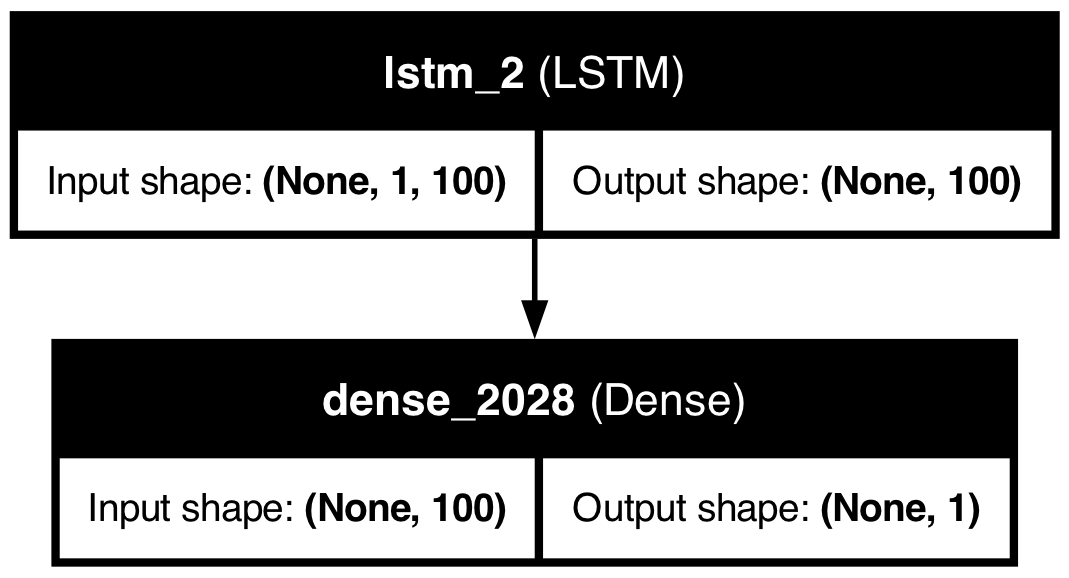

In [108]:
# Generate the plot
plot_model(model_2c, show_shapes=True, show_layer_names=True)

In [109]:
# Reshape the data for LSTM: [samples, time steps, features]
cX_train_lstm = cX_train_vec.reshape(cX_train_vec.shape[0], 1, cX_train_vec.shape[1])
cX_test_lstm = cX_test_vec.reshape(cX_test_vec.shape[0], 1, cX_test_vec.shape[1])


# Train the model
history = model_2c.fit(cX_train_lstm, cy_train, epochs=40, batch_size=10, validation_split=0.2,)


Epoch 1/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5153 - loss: 0.6948 - val_accuracy: 0.5938 - val_loss: 0.6811
Epoch 2/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5742 - loss: 0.6795 - val_accuracy: 0.6080 - val_loss: 0.6687
Epoch 3/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6126 - loss: 0.6588 - val_accuracy: 0.6110 - val_loss: 0.6359
Epoch 4/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6421 - loss: 0.6384 - val_accuracy: 0.6257 - val_loss: 0.6236
Epoch 5/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6509 - loss: 0.6243 - val_accuracy: 0.6778 - val_loss: 0.6047
Epoch 6/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6624 - loss: 0.6152 - val_accuracy: 0.6439 - val_loss: 0.6034
Epoch 7/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6750 - loss: 0.6001 - val_accuracy: 0.6930 - val_loss: 0.5931
Epoch 8/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6723 - loss: 0.5975 - val_accuracy: 0

In [110]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_2c.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2c_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2c_accuracy = accuracy_score(cy_test, cy_pred)
m2c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2c_recall = recall_score(cy_test, cy_pred, average='weighted')
m2c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2c_accuracy:.2%}", f"{m2c_precision:.3f}", f"{m2c_recall:.3f}", f"{m2c_f1:.3f}", f"{m2c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Model Performance          Results
         accuracy           69.26%
        precision            0.702
           recall            0.693
         f1_score            0.689
    time/instance 0.000959 seconds


In [111]:
store_results('Model_2c', m2c_accuracy, m2c_precision, m2c_recall, m2c_f1, m2c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   72.01%     0.725  0.720    0.718  0.000132 seconds
3   Model_1r   49.23%     0.425  0.492    0.345  0.000145 seconds
4   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
5   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
6   Model_1r   56.96%     0.654  0.570    0.501  0.000137 seconds
7   Model_1r   68.85%     0.747  0.689    0.669  0.000130 seconds
8   Model_1c   71.64%     0.719  0.716    0.716  0.000145 seconds
9   Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
10  Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
11  Model_1c   73.22%     0.740  0.732    0.730  0.000415 seconds
12  Model_1r   69.70%     0.713  0.697    0.691  0.000236 seconds
13  Model_2c   69.26%     0.702  0.693    0.689  0.000959 seconds


In [112]:
grid_result = grid.fit(rX_train_vec.reshape(-1, 1, 100), ry_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

46233.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.56s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.61s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
46233.67s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will 

Best: 0.690915 using {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 50}
0.667039 (0.012586) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.01, 'lstm_units': 20}
0.676345 (0.013893) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.01, 'lstm_units': 50}
0.668961 (0.006400) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.01, 'lstm_units': 100}
0.670072 (0.011639) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.001, 'lstm_units': 20}
0.671085 (0.002232) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.001, 'lstm_units': 50}
0.647613 (0.037181) with: {'batch_size': 10, 'epochs': 5, 'learning_rate': 0.001, 'lstm_units': 100}
0.684035 (0.007183) with: {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 20}
0.684541 (0.011034) with: {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 50}
0.676854 (0.015752) with: {'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'lstm_units': 100}
0.68

In [113]:
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_learning_rate = best_params['learning_rate']

In [114]:
# Create the model with the best parameters found
model_2r = create_best_model(best_lstm_units, best_learning_rate)

# Model Summary
print(model_2r.summary())

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_653"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2030 (Dense)              │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,251 (118.17 KB)

 Trainable params: 30,251 (118.17 KB)

 Non-trainable params: 0 (0.00 B)

None


In [115]:
# Reshape the data for LSTM: [samples, time steps, features]
rX_train_lstm = rX_train_vec.reshape(rX_train_vec.shape[0], 1, rX_train_vec.shape[1])
rX_test_lstm = rX_test_vec.reshape(rX_test_vec.shape[0], 1, rX_test_vec.shape[1])

# Train the model
history = model_2r.fit(rX_train_lstm, ry_train, epochs=40, batch_size=10, validation_split=0.2,)

Epoch 1/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.5910 - loss: 0.6683 - val_accuracy: 0.6555 - val_loss: 0.6314
Epoch 2/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6628 - loss: 0.6224 - val_accuracy: 0.6722 - val_loss: 0.6090
Epoch 3/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6534 - loss: 0.6142 - val_accuracy: 0.6803 - val_loss: 0.6015
Epoch 4/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6646 - loss: 0.6026 - val_accuracy: 0.6216 - val_loss: 0.6325
Epoch 5/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6775 - loss: 0.5912 - val_accuracy: 0.6859 - val_loss: 0.5928
Epoch 6/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6746 - loss: 0.5972 - val_accuracy: 0.6874 - val_loss: 0.5939
Epoch 7/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6839 - loss: 0.5934 - val_accuracy: 0.6788 - val_loss: 0.5918
Epoch 8/40
791/791 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6761 - loss: 0.5966 - val_accuracy: 0

In [116]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
ry_pred_prob = model_2r.predict(rX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
ry_pred = (ry_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m2r_time_per_instance = (end_time - start_time) / len(rX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m2r_accuracy = accuracy_score(ry_test, ry_pred)
m2r_precision = precision_score(ry_test, ry_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m2r_recall = recall_score(ry_test, ry_pred, average='weighted')
m2r_f1 = f1_score(ry_test, ry_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m2r_accuracy:.2%}", f"{m2r_precision:.3f}", f"{m2r_recall:.3f}", f"{m2r_f1:.3f}", f"{m2r_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Model Performance          Results
         accuracy           71.72%
        precision            0.717
           recall            0.717
         f1_score            0.717
    time/instance 0.001267 seconds


In [117]:
store_results('Model_2r', m2r_accuracy, m2r_precision, m2r_recall, m2r_f1, m2r_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   72.01%     0.725  0.720    0.718  0.000132 seconds
3   Model_1r   49.23%     0.425  0.492    0.345  0.000145 seconds
4   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
5   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
6   Model_1r   56.96%     0.654  0.570    0.501  0.000137 seconds
7   Model_1r   68.85%     0.747  0.689    0.669  0.000130 seconds
8   Model_1c   71.64%     0.719  0.716    0.716  0.000145 seconds
9   Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
10  Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
11  Model_1c   73.22%     0.740  0.732    0.730  0.000415 seconds
12  Model_1r   69.70%     0.713  0.697    0.691  0.000236 seconds
13  Model_2c   69.26%     0.702  0.693    0.689  0.000959 seconds
14  Model_

### LSTM (stacked) with cleaned and raw data

In [118]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_model(lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(1, cX_train_vec.shape[1])))  
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [120]:
model = KerasClassifier(build_fn=create_model, dropout_rate=0.1, lstm_units=50,verbose=0)

# Define the grid search parameters
param_grid = {
    'lstm_units': [50, 100, 150],  # LSTM units
    'dropout_rate': [0.1, 0.2, 0.3],  # Dropout rates
    'batch_size': [32, 64],  # Batch sizes
    'epochs': [20]  # Number of epochs
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

grid_result = grid.fit(cX_train_lstm, cy_train)

python(66323) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66324) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66325) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66326) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66327) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66328) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(66330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
51826.43s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
51826.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
51826.49s - pydevd: Send

In [122]:
# Evaluate the best model
best_model = grid_result.best_estimator_

print(f"Best Model Test Loss: {test_loss}")
print(f"Best Model Test Accuracy: {test_accuracy}")

Best Model Test Loss: 0.5847359299659729
Best Model Test Accuracy: 0.708737850189209


In [124]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.719445 using {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 100}
0.714487 (0.007554) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 50}
0.708014 (0.008844) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 100}
0.705176 (0.026594) with: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 20, 'lstm_units': 150}
0.714891 (0.012923) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 50}
0.719445 (0.009962) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 100}
0.713679 (0.005183) with: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 20, 'lstm_units': 150}
0.696681 (0.012780) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 50}
0.712565 (0.004132) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 100}
0.688285 (0.010943) with: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 20, 'lstm_units': 150}
0.700932 (0.014075

In [126]:
best_params = grid_result.best_params_
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = grid_result.best_params_['batch_size']

In [127]:
model_3c = create_model(best_lstm_units, best_dropout_rate)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


python(67409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


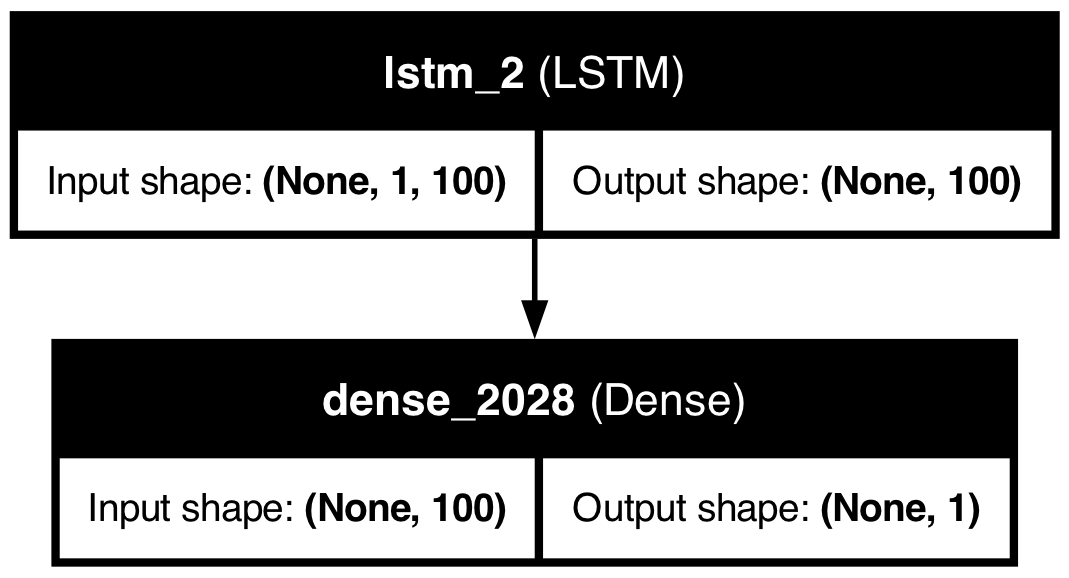

In [128]:
# Generate the plot
plot_model(model_2c, show_shapes=True, show_layer_names=True)

In [129]:
model_3c_history= model_3c.fit(cX_train_lstm, cy_train, epochs=50, batch_size=best_batch_size, validation_split=0.2)

Epoch 1/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.5121 - loss: 0.6931 - val_accuracy: 0.4982 - val_loss: 0.6916
Epoch 2/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5331 - loss: 0.6888 - val_accuracy: 0.5867 - val_loss: 0.6640
Epoch 3/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5875 - loss: 0.6714 - val_accuracy: 0.6535 - val_loss: 0.6435
Epoch 4/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6434 - loss: 0.6376 - val_accuracy: 0.6075 - val_loss: 0.6338
Epoch 5/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6509 - loss: 0.6279 - val_accuracy: 0.6343 - val_loss: 0.6178
Epoch 6/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6268 - loss: 0.6442 - val_accuracy: 0.6697 - val_loss: 0.6076
Epoch 7/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6818 - loss: 0.5956 - val_accuracy: 0.6778 - val_loss: 0.6041
Epoch 8/50
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6674 - loss: 0.6054 - val_accuracy: 

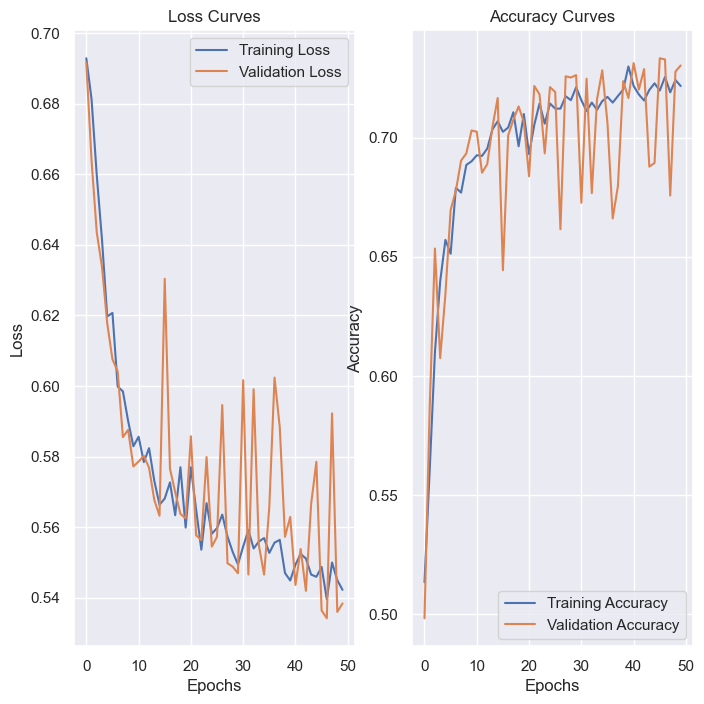

In [130]:
plot_loss_curves(model_3c_history)

In [131]:
# Predicting the ratings and measuring the time it takes
start_time = timeit.default_timer()
cy_pred_prob = model_3c.predict(cX_test_lstm)  # This returns probabilities
end_time = timeit.default_timer()

# Convert probabilities to binary predictions
cy_pred = (cy_pred_prob > 0.5).astype(int)  # Converts probs to 0 or 1 based on threshold 0.5

# Calculate time per instance
m3c_time_per_instance = (end_time - start_time) / len(cX_test_lstm)

# Calculate accuracy, precision, recall, and f1 score
m3c_accuracy = accuracy_score(cy_test, cy_pred)
m3c_precision = precision_score(cy_test, cy_pred, average='weighted')  # Use 'weighted' to account for label imbalance
m3c_recall = recall_score(cy_test, cy_pred, average='weighted')
m3c_f1 = f1_score(cy_test, cy_pred, average='weighted')

# Display the results in a formatted way
results = pd.DataFrame({
    'Model Performance': ['accuracy', 'precision', 'recall', 'f1_score', 'time/instance'],
    'Results': [f"{m3c_accuracy:.2%}", f"{m3c_precision:.3f}", f"{m3c_recall:.3f}", f"{m3c_f1:.3f}", f"{m3c_time_per_instance:.6f} seconds"]
})

print(results.to_string(index=False))

78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Model Performance          Results
         accuracy           72.65%
        precision            0.732
           recall            0.727
         f1_score            0.725
    time/instance 0.001895 seconds


In [132]:
store_results('Model_3c', m3c_accuracy, m3c_precision, m3c_recall, m3c_f1, m3c_time_per_instance)

# View the consolidated results
print(results_df)

       Model Accuracy Precision Recall F1 Score Time per Instance
0   Model_0c   78.80%     0.793  0.788    0.787  0.000000 seconds
1   Model_0r   78.92%     0.795  0.789    0.788  0.000000 seconds
2   Model_1c   72.01%     0.725  0.720    0.718  0.000132 seconds
3   Model_1r   49.23%     0.425  0.492    0.345  0.000145 seconds
4   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
5   Model_1r   63.19%     0.689  0.632    0.602  0.000066 seconds
6   Model_1r   56.96%     0.654  0.570    0.501  0.000137 seconds
7   Model_1r   68.85%     0.747  0.689    0.669  0.000130 seconds
8   Model_1c   71.64%     0.719  0.716    0.716  0.000145 seconds
9   Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
10  Model_1r   70.79%     0.745  0.708    0.696  0.000172 seconds
11  Model_1c   73.22%     0.740  0.732    0.730  0.000415 seconds
12  Model_1r   69.70%     0.713  0.697    0.691  0.000236 seconds
13  Model_2c   69.26%     0.702  0.693    0.689  0.000959 seconds
14  Model_